## Load the processed version of the data file

In [2]:
import time
import sys
import numpy as np
import pandas as pd

In [3]:
#takes about 40 secs to load
path = 'data/processed/LoanStats-combined-2.csv'
t1 = time.time()
df = pd.read_csv(path)
t2 = time.time()
print "{} bytes loaded in {:0.3f} secs".format(sys.getsizeof(df),t2-t1)
print df.shape


/Users/stephane/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (19,47,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2073973247 bytes loaded in 26.022 secs
(887382, 147)


## Finally, create a list of features for fitting a model

As a first pass, I'm only pulling out numeric features. Text processing can be added later.

In [4]:
# I spent an unnecessary amount of time figuring out how to do this, and it turns out there's  a builtin for it...
num_cols=list(df._get_numeric_data().columns) 
# remove cols we won't use for model fitting
rem_cols = ['lc_id', 'member_id', 'loan_status_num', 'grade_num']
for r in rem_cols:
    num_cols.remove(r)
#print num_cols
print len(num_cols)
print num_cols

118
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', '

## Need to avoid using some features that represent information gained after the loan status

In [5]:
skippers = [
    'collection_recovery_fee',
    'out_prncp',
    'out_prncp_inv',
    'pymnt_plan',
    'recoveries',
    'sub_grade',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp'
    ]
for r in skippers:
    if r in num_cols:
        num_cols.remove(r)
    

## After all that, finally ready to try to fit something?

In [6]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics


### Initially, downsample the DataFrame for quicker testing

In [7]:
minidf=df.sample(n=10000,random_state=33)
minidf.sort_values(by='grade_num',inplace=True)
print df.shape
print minidf.shape

(887382, 147)
(10000, 147)


### NaNs are a problem, so one more filtering step:

In [18]:
validindexlist=(minidf.loan_status_num ==1) | (minidf.loan_status_num == 0)
#X = df[num_cols][validindexlist].fillna(0)
#X = pd.DataFrame(minidf['grade_num'][validindexlist].fillna(0)) # just grade num, like before
#X = pd.DataFrame(
#    df[(list(['grade_num'])+num_cols)[0:10]][validindexlist].fillna(0)) # new vals + grade_num
# X = pd.DataFrame(minidf[num_cols[0:10]][validindexlist].fillna(0)) # just a few new features
X = minidf[num_cols][validindexlist].fillna(0)
y = minidf.loan_status_num[validindexlist].fillna(0)
print type(X) ,X.shape
print type(y), y.shape
print 'done'

<class 'pandas.core.frame.DataFrame'> (9742, 109)
<class 'pandas.core.series.Series'> (9742,)
done


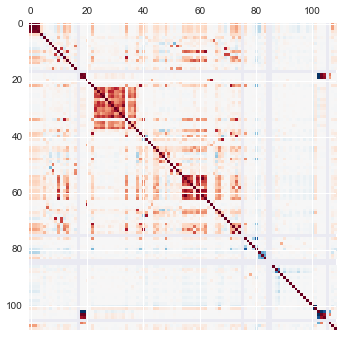

In [19]:
plt.figure(figsize=(16, 16))
corr = X.corr()
plt.matshow(corr,cmap=plt.cm.RdBu_r)
#plt.xticks(range(len(corr.columns)), corr.columns);
#plt.yticks(range(len(corr.columns)), corr.columns);

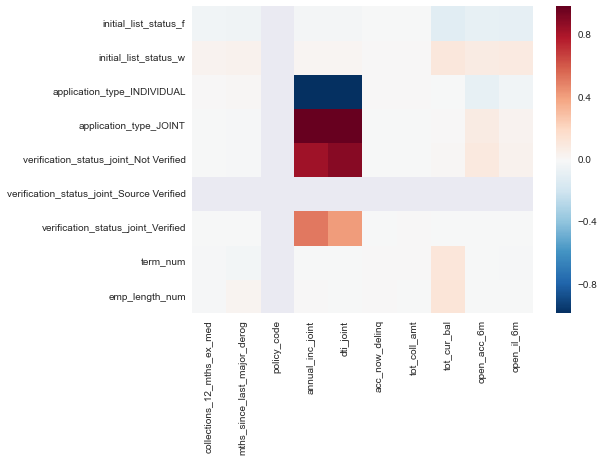

In [34]:
import seaborn as sns
sns.heatmap(corr[corr.columns[15:25]].iloc[100:], vmax=.8, square=True)

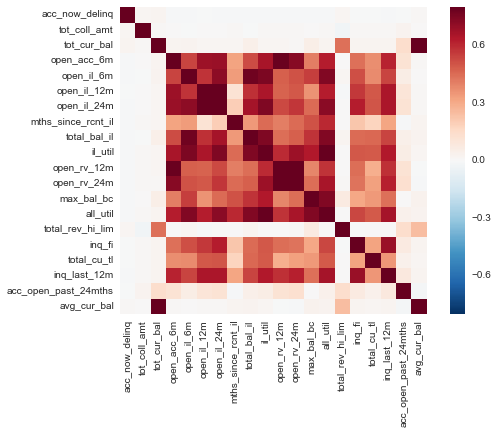

In [35]:
import seaborn as sns
sns.heatmap(corr[corr.columns[20:40]].iloc[20:40], vmax=.8, square=True)

In [30]:
corr[corr.columns[15:25]].tail(10)

,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m
purpose_wedding,-0.005847,-0.020537,NaN,-0.001090,-0.001090,-0.003480,-0.006031,-0.035338,-0.005570,-0.005974
initial_list_status_f,-0.036040,-0.046008,NaN,-0.020560,-0.020559,-0.003210,-0.001371,-0.108132,-0.083483,-0.090846
initial_list_status_w,0.036040,0.046008,NaN,0.020560,0.020559,0.003210,0.001371,0.108132,0.083483,0.090846
application_type_INDIVIDUAL,0.002169,0.010142,NaN,-0.984458,-0.984436,0.001291,0.001083,-0.004079,-0.079751,-0.034648
application_type_JOINT,-0.002169,-0.010142,NaN,0.984458,0.984436,-0.001291,-0.001083,0.004079,0.079751,0.034648
verification_status_joint_Not Verified,-0.001878,-0.008783,NaN,0.835779,0.894356,-0.001118,-0.001532,0.008004,0.092681,0.040646
verification_status_joint_Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
verification_status_joint_Verified,-0.001084,-0.005070,NaN,0.521150,0.419659,-0.000645,0.000488,-0.005704,-0.001033,-0.001108
term_num,-0.012971,-0.028608,NaN,-0.001036,-0.003306,0.005385,0.004966,0.120277,-0.003574,-0.008900
emp_length_num,-0.010113,0.025813,NaN,0.001313,-0.003643,0.001668,-0.003964,0.123455,-0.000765,-0.000275


### Fit a bunch of logregs?


In [58]:
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from operator import itemgetter

#scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
# from 
# http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html
# example-model-selection-randomized-search-py
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

logreg = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

# run grid search
grid_search = GridSearchCV(logreg, param_grid=param_grid)
start = time.time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)
logreg = grid_search.best_estimator_

GridSearchCV took 14.22 seconds for 7 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.940 (std: 0.002)
Parameters: {'C': 0.1}

Model with rank: 2
Mean validation score: 0.940 (std: 0.001)
Parameters: {'C': 0.001}

Model with rank: 3
Mean validation score: 0.940 (std: 0.002)
Parameters: {'C': 0.01}



In [68]:
print len(grid_search.grid_scores_)
print type(grid_search.grid_scores_[0])
print grid_search.grid_scores_[0]
print grid_search.best_score_

7
<class 'sklearn.grid_search._CVScoreTuple'>
mean: 0.93978, std: 0.00126, params: {'C': 0.001}
0.939912400766


## Okay, how did the model do?

In [82]:
from sklearn.cross_validation import cross_val_predict
#y_pred_class = cross_val_predict(logreg, X, y, cv=10)
y_pred_class = grid_search.predict(X_test)
y_pred_prob = grid_search.predict_proba(X_test)[:,1]

In [83]:
#y_test = y
print "percent of loans successful in y_test: {}/{} = {}".format(
    y_test[y_test == 1].count(), y_test.count(),
    float(y_test[y_test == 1].count())/ y_test.count() )
print metrics.accuracy_score(y_test,y_pred_class)

percent of loans successful in y_test: 2298/2436 = 0.943349753695
0.942939244663


In [84]:
print "percent of loans successful in y_test: {}/{} = {}".format(
    y_test[y_test == 1].count(), y_test.count(),
    float(y_test[y_test == 1].count())/ y_test.count() )
print "percent of loans predicted to be successful: {}/{} = {}".format(
    y_pred_class.sum() , len(y_pred_class),
    float(y_pred_class.sum())/len(y_pred_class))
                                                                 
a = [i for i,x in enumerate(y_pred_class) if x != 1] # false predictions
print len(a), a
print y[a]
#print logreg2.classes_
#print y_pred_prob[a]
#print y_pred_prob[0:3]

print 'done'

percent of loans successful in y_test: 2298/2436 = 0.943349753695
percent of loans predicted to be successful: 2431.0/2436 = 0.997947454844
5 [91, 597, 908, 1497, 2268]
91     NaN
597    NaN
908    NaN
1497   NaN
2268   NaN
Name: loan_status_num, dtype: float64
done


### (this will be a good spot for a confusion matrix)

In [85]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print confusion
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]
print 'True Positives:', TP
print 'True Negatives:', TN
print 'False Positives:', FP
print 'False Negatives:', FN
# calculate the sensitivity
print TP / float(TP + FN)
# calculate the specificity
print TN / float(TN + FP)

[[   2  136]
 [   3 2295]]
True Positives: 2295
True Negatives: 2
False Positives: 136
False Negatives: 3
0.998694516971
0.0144927536232


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1373fd3d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x137971610>], dtype=object)

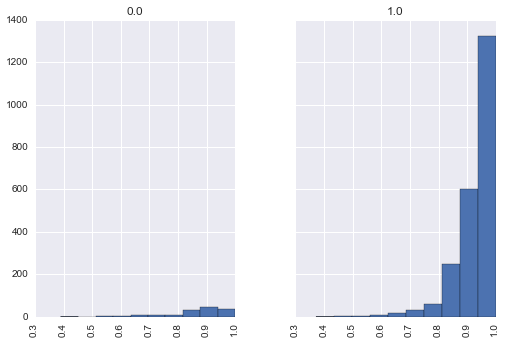

In [89]:
tempdf = pd.DataFrame({'probability':y_pred_prob, 'actual':y_test})
tempdf.hist(column='probability', by='actual', sharex=True, sharey=True)

0.721478033829


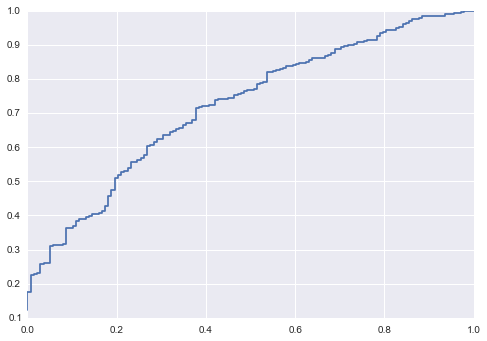

In [90]:
# ROC curve 
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
print metrics.roc_auc_score(y_test, y_pred_prob)

### To check results of the fit, plot the predicted probabilities

This was a first attempt to view a correlation between the predicted probabilities and the outcomes of the loans. I hoped to see more 'defaults' (black points) toward the left, at the lower probabilities. However this graph didn't work very well.

/Users/stephane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


<class 'pandas.core.series.Series'>
2436 2436
1.0 0.0
(2436,) (2436,) 2436 (2436,)


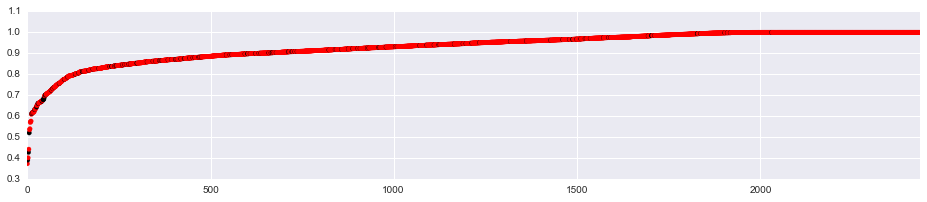

In [91]:
sis = y_pred_prob.argsort()
colormap = np.array(['k', 'r'])
plt.figure(figsize=(16, 3))
plt.scatter(range(len(y_pred_prob)),y_pred_prob[sis],color=colormap[list(y_test.iloc[sis])])
plt.xlim([0,len(y_test)])
#plt.scatter(range(len(y_test)),y_test.iloc[sis],color=colormap[list(y_test.iloc[sis])])
print type(y_test)

print len(y_test),len(sis)
print max(y_test),min(y_test)
print y_test.shape,sis.shape,len(y_test[sis]),y_test[sis].shape

### Second attempt to evaluate the model graphically

This graph shows a boxplot of predicted probabilities broken down into 2 groups based on outcome. It is clear that 'successful' loans (loan_status_num ==1) have a higher distribution of predicted probabilites than 'unsuccessful' loans (loan_status_num == 0).

1.0    2298
0.0     138
Name: loan_status_num, dtype: int64


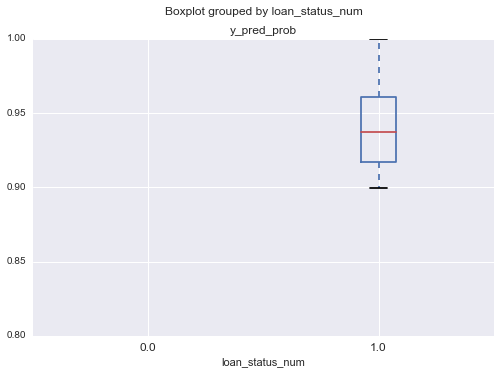

In [92]:
# merge these things into a single dataframe for plotting:
testdf=pd.concat([X_test,y_test,pd.DataFrame(y_pred_prob,columns=['y_pred_prob'])],axis=1)
testdf.boxplot(column='y_pred_prob',by='loan_status_num')
print testdf.loan_status_num.value_counts()

In [94]:
grouped = testdf.groupby('loan_status_num')
grouped.y_pred_prob.quantile([.25, .5, .75, 1])


loan_status_num
0.0                                                  NaN
1.0    0.25    0.916912
0.50    0.937018
0.75    0.96...
Name: y_pred_prob, dtype: object

In [95]:
#plt.scatter(df.grade_num,df.loan_status_num,label='loan status')
#plt.plot(df2.grade_num,df2.loan_status_pred_num,color='red')
#plt.plot(X_test['grade_num'].sort_values(),y_pred_class,color='red')
#plt.setp(plt.gca(), xticklabels=gradenames, xticks = gradenums)
#plt.setp(plt.gca(), yticklabels=np.arange(0,1.2,.2), yticks = np.arange(0,1.2,.2))
#plt.setp(plt.gca(),title = 'Predicted loan status, test set')

## next...

In [96]:
print 'done'

done


In [97]:
#print total_success_rate
print "percent of loans successful in y_test: {}/{} = {}".format(y_test[y_test == 1].count(), y_test.count(),
                                                       float(y_test[y_test == 1].count())/ y_test.count() )
print "logreg class prediction accuracy:" , metrics.accuracy_score(y_test, y_pred_class)
print "guess all successful accuracy: ", metrics.accuracy_score(y_test,[1]*len(y_test))

percent of loans successful in y_test: 2298/2436 = 0.943349753695
logreg class prediction accuracy: 0.942939244663
guess all successful accuracy:  0.943349753695


In [98]:
grouped=minidf.groupby('grade')
probs=grouped.loan_status_num.sum()/grouped.loan_status_num.count()
print probs

grade
A    0.973794
B    0.964311
C    0.944033
D    0.906397
E    0.874317
F    0.839827
G    0.830508
Name: loan_status_num, dtype: float64


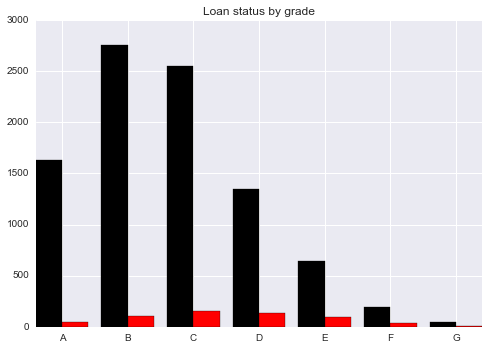

In [99]:
fig,ax = plt.subplots()
width=.4
xlocs=np.arange(0,7)
ax.bar(xlocs-width,grouped.loan_status_num.sum(),width,color='k')
ax.set_xticks(xlocs)
ax.set_xticklabels(sorted(minidf.grade.unique()))
ax.bar(
        xlocs,grouped.loan_status_num.apply(lambda item: (item == 0).sum()),width,
        color='r')
ax.set_title('Loan status by grade')

KeyError: 'grade_num'

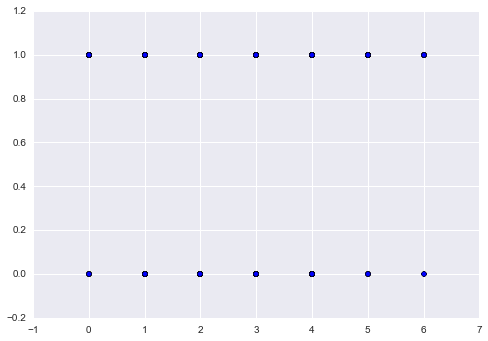

In [100]:
#df2['loan_status_pred_prob']=logreg.predict_proba(X)[:,1]
plt.scatter(minidf.grade_num,minidf.loan_status_num)
#plt.plot(df2.grade_num,df2.loan_status_pred_prob,color='red')
X_test_s=X_test.sort_values(by='grade_num').grade_num.reshape(-1,1)
plt.plot(X_test_s,logreg2.predict_proba(X_test_s)[:,1],color='red')

plt.plot(probs,'go-')